In [1]:
%matplotlib inline
from __future__ import division, print_function, absolute_import
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from numpy.linalg import norm
import math

In [2]:
points = np.load("Parabola.Points.1000.npy")
labels = np.load("Parabola.Labels.1000.npy")

In [3]:
#print(points)
#print(labels)
#print(points[:-100,:].shape)

# Number of support vectors:
| C        | Gamma    | Number of Support Vectors | Accuracy | Comments |
|----------|----------|---------------------------|----------|----------|
|1         | 0.01     | 189                       | 0.98     |          |
|100       | 0.01     | 102                       | 0.98     |          |
|1         | 0.001    | 155                       | 0.99     |          |
|100       | 0.001    | 37                        | 1.00     | BEST     |
|1         | 0.0001   | 378                       | 0.88     |          |
|100       | 0.0001   | 108                       | 1.00     |          |

In [4]:
gamma=0.001
clf = SVC(C=100, gamma=gamma)
print(clf)
clf.fit(points[:-100,:], labels[:-100])

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [5]:
numcorrect = 0
for (point, label) in zip(points[-100:,:], labels[-100:]):
    prediction = clf.predict([point])
#    print("Point: " + str(point) + " Label: " + str(label) + " Prediction: " + str(prediction))
    if label == prediction:
        numcorrect += 1
    else:
        print("INACCURATE PREDICTION!!: Point: " + str(point) + " Label: " + str(label) + " Prediction: " + str(prediction))
print("Accuracy: " + str(float(numcorrect)/100.0))

Accuracy: 1.0


In [6]:
#print(clf.support_.shape)

In [7]:
print(str(clf.support_vectors_.shape))

(37, 2)


In [8]:
prediction_at_support = np.empty(clf.support_vectors_.shape[0])
i = 0
for (x, y) in clf.support_vectors_:
    prediction_at_support[i] = clf.predict([[x,y]])
    i += 1
print(prediction_at_support.shape)
#print(prediction_at_support)

(37,)


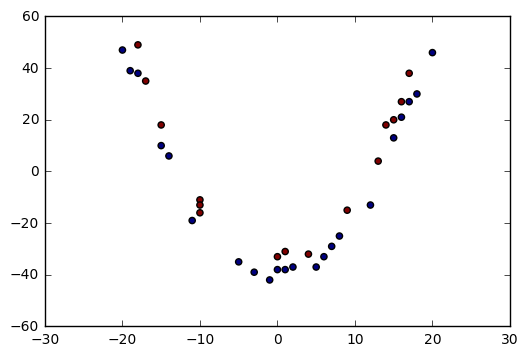

In [9]:
plt.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:,1], c=prediction_at_support[:] )
plt.show()

In [10]:
num_support_vectors = clf.dual_coef_.shape[1]
print(num_support_vectors)

37


In [11]:
clf.decision_function(clf.support_vectors_)

array([-0.37857815, -0.99965529, -0.57051416, -0.99965946, -0.99999491,
       -0.13181328, -0.9999127 , -0.99994382, -0.54286645, -0.98992585,
       -1.00026252, -1.00015163, -0.99992549, -0.82702449, -1.00040643,
       -0.87461592,  0.33237653, -1.00016148, -0.90454273, -0.74668872,
        1.00059202,  1.00001283,  0.99978534, -0.22321357,  0.38155552,
        0.68809502,  0.87712216,  1.00012583,  0.29013498, -0.23443283,
        0.9997275 ,  0.7349251 , -0.18193399,  0.67903587,  0.05056191,
        0.99983902,  0.76082975])

In [12]:
alpha_i = np.empty(num_support_vectors)
y_i = np.empty(num_support_vectors, dtype=np.int)
for i in range(num_support_vectors):
    alpha_i[i] = clf.dual_coef_[0][i]
    y_i[i] = (1 if prediction_at_support[i] == 1 else -1)

In [13]:
def gaussian_kernel_function(point1, point2, gamma):
    to_return = math.exp(-1.0*gamma*((norm(point1-point2))**2))
    #print(to_return)
    return to_return

In [14]:
def calculate_raw_prediction(point):
    #This is sum over all support vectors of alpha_i * y_i * kernel_based_dot_product(support_vector_i, point) + b
    accumulate = 0.0
    for i in range(num_support_vectors):
        support_vector_point = np.array([clf.support_vectors_[i][0], clf.support_vectors_[i][1]])
        kernel_func_result = gaussian_kernel_function(point, support_vector_point, gamma)
        accumulate += alpha_i[i]*kernel_func_result
    return (accumulate + clf.intercept_)

In [15]:
support_vector_raw_prediction = np.empty(num_support_vectors)
for i in range(num_support_vectors):
    support_vector_point = np.array([clf.support_vectors_[i][0],clf.support_vectors_[i][1]])
    support_vector_raw_prediction[i] = calculate_raw_prediction(support_vector_point)
    print("Support vector: x=" + str(clf.support_vectors_[i][0]) + ",y=" + str(clf.support_vectors_[i][1]) + 
          ", Alpha_i=" + str(alpha_i[i]) + ",y_i=" + str(y_i[i]) + ", Raw prediction=" + 
          str(support_vector_raw_prediction[i]))
print("Intercept:" + str(clf.intercept_))

Support vector: x=15.0,y=13.0, Alpha_i=-100.0,y_i=-1, Raw prediction=-0.378578150211
Support vector: x=-1.0,y=-42.0, Alpha_i=-45.1454164609,y_i=-1, Raw prediction=-0.99965529158
Support vector: x=17.0,y=27.0, Alpha_i=-100.0,y_i=-1, Raw prediction=-0.570514155992
Support vector: x=7.0,y=-29.0, Alpha_i=-78.6489180973,y_i=-1, Raw prediction=-0.999659457055
Support vector: x=6.0,y=-33.0, Alpha_i=-72.147498301,y_i=-1, Raw prediction=-0.999994911018
Support vector: x=-18.0,y=38.0, Alpha_i=-100.0,y_i=-1, Raw prediction=-0.13181328182
Support vector: x=-15.0,y=10.0, Alpha_i=-32.9044708513,y_i=-1, Raw prediction=-0.999912695023
Support vector: x=-11.0,y=-19.0, Alpha_i=-61.205902635,y_i=-1, Raw prediction=-0.999943822353
Support vector: x=16.0,y=21.0, Alpha_i=-100.0,y_i=-1, Raw prediction=-0.542866453432
Support vector: x=5.0,y=-37.0, Alpha_i=-100.0,y_i=-1, Raw prediction=-0.989925846187
Support vector: x=20.0,y=46.0, Alpha_i=-11.50943334,y_i=-1, Raw prediction=-1.00026251819
Support vector: x=-

In [16]:
def distance(point1, point2):
    return norm(point1 - point2)

In [17]:
def get_closest_opposite_label_point_in_dataset(point):
    prediction = clf.predict([point])
    opposite_label = 1 - prediction
    opposite_data_indices = np.empty((0), dtype=np.int)
    for i in range(points.shape[0]):
        if labels[i] == opposite_label:
            opposite_data_indices = np.append(opposite_data_indices, i)
    min = float('inf')
    index = -1
    for i in range(opposite_data_indices.shape[0]):
        dist = distance(point, np.array([points[opposite_data_indices[i]]]))
        if (dist < min):
            min = dist
            index = opposite_data_indices[i]
    return (min, index, points[index] if index != -1 else None)

In [18]:
def get_reference_point_from_closest_opposite_label_point(point, step=0.001):
    (dist, index, opposite_point) = get_closest_opposite_label_point_in_dataset(point)
    #1. Opposite point is likely much closer to the separating hyperplane
    #2. Starting from there, calculate unit vector from opposite point to point
    length = distance(point, opposite_point)
    unit = (point - opposite_point)/length
    # Choose a step and move in steps until you just pass the zero point
    passed = False
    current = np.copy(opposite_point)
    starting_prediction = calculate_raw_prediction(current)
    while not passed and distance(current, point) > step:
        current += step*unit
        new_prediction = calculate_raw_prediction(current)
        if new_prediction*starting_prediction < 0: 
            #new_prediction must have switched sign
            passed = True
    return (current, calculate_raw_prediction(current))   

In [19]:
def get_gradient(point, dx=0.001):
    grad = np.zeros_like(point, dtype=np.float)
    point_prediction = calculate_raw_prediction(point)
    for i in range(point.shape[0]):
        # Calculate partial derivative for each element of vector
        # First, move by increment in direction of ith element
        copy = np.copy(point)
        copy[i] += dx
        # Then find predicton at that point and calculate dy/dx
        dy = calculate_raw_prediction(copy) - point_prediction
        grad[i] = dy/dx
    return grad

In [20]:
def get_average_gradient_between_points(from_point, to_point, step=0.01):
    length = distance(from_point, to_point)
    unit = (to_point - from_point)/length
    grad = get_gradient(from_point)
    num_points = 1
    current_point = np.copy(from_point)
    while distance(current_point, to_point) >= step:
        current_point += step*unit
        num_points += 1
        grad += get_gradient(current_point)
    average_grad = grad/float(num_points)
    return average_grad

In [21]:
def get_importance_score(point):
    (reference_point, prediction) = get_reference_point_from_closest_opposite_label_point(point)
    average_grad = get_average_gradient_between_points(reference_point, point)
    importance_score = np.zeros_like(point, dtype=np.float)
    for i in range(point.shape[0]):
        importance_score[i] = (point[i] - reference_point[i]) * average_grad[i]
    return importance_score

In [22]:
display_points = np.empty((0,5), dtype=float)
for x in range(-50,60,20):
    for y in range(-50,60,20):
        point = np.array([x,y])
        raw_pred = calculate_raw_prediction(point)
        imp = get_importance_score(point)
        display_points = np.append(display_points, [[x, y, raw_pred, imp[0], imp[1]]], axis=0)

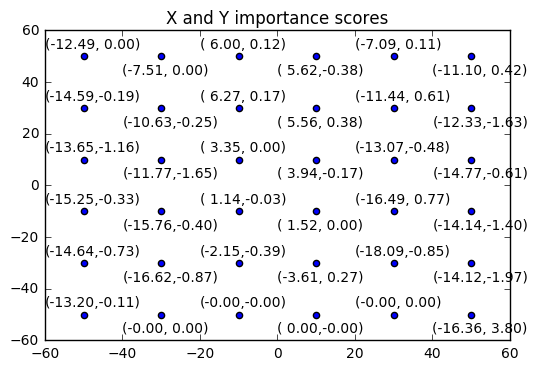

In [23]:
plt.scatter(display_points[:,0], display_points[:,1])
for i in range(display_points.shape[0]):
    x = display_points[i][0]
    y = display_points[i][1]
    raw_pred = display_points[i][2]
    impx = display_points[i][3]
    impy = display_points[i][4]
    if (x+10)/20 % 2 == 0:
        plt.annotate('(%5.2f,%5.2f)' %(impx, impy), xy=(x,y), xytext=(x-10,y+3))
    else:
        plt.annotate('(%5.2f,%5.2f)' %(impx, impy), xy=(x,y), xytext=(x-10,y-7))
plt.title('X and Y importance scores')
plt.show()

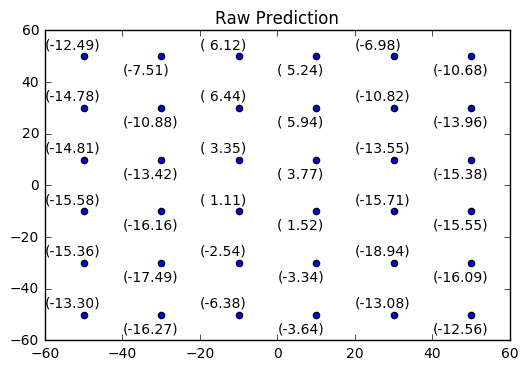

In [24]:
plt.scatter(display_points[:,0], display_points[:,1])
for i in range(display_points.shape[0]):
    x = display_points[i][0]
    y = display_points[i][1]
    raw_pred = display_points[i][2]
    if (x+10)/20 % 2 == 0:
        plt.annotate('(%5.2f)' %(raw_pred), xy=(x,y), xytext=(x-10,y+3))
    else:
        plt.annotate('(%5.2f)' %(raw_pred), xy=(x,y), xytext=(x-10,y-7))
plt.title('Raw Prediction')
plt.show()